In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Kaggle BBC Data

In [ ]:
from tqdm import tqdm
from nltk.corpus import stopwords
import os
import nltk
nltk.download('stopwords')

def extract(filepath):
    pattern = r'(\w+)/(\d+)\.txt$'
    category, file_id = re.search(pattern, str(filepath)).groups()
    with open(filepath, 'r', encoding='unicode_escape') as f:
        text = f.read()
        return category, file_id, text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import pandas as pd
from pathlib import Path
dataset_path = Path('/content/drive/MyDrive/NLP_Project/BBC News Summary')

articles_data = list(map(extract, dataset_path.glob('News Articles/*/*.txt')))
summaries_data = list(map(extract, dataset_path.glob('Summaries/*/*.txt')))

articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'Article'))
summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'Summary'))

In [ ]:
data = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))

In [ ]:
from tqdm import tqdm

grouped = data.groupby(data.Category)

df_business = grouped.get_group("business")
df_entertainment = grouped.get_group("entertainment")
df_politics = grouped.get_group("politics")
df_sport = grouped.get_group("sport")
df_tech = grouped.get_group("tech")

In [ ]:
data_list=[df_business,df_entertainment,df_politics,df_sport,df_tech]

#Metrics

In [ ]:
!pip install rouge

from rouge import Rouge

rouge = Rouge()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sumeval &> /dev/null

In [ ]:
from sumeval.metrics.rouge import RougeCalculator 

def rouge_scores(s,os):
    rouge = RougeCalculator(stopwords=True, lang="en") 

    rouge_1 = rouge.rouge_n(
                summary=s,
                references=os,
                n=1)
    rouge_2 = rouge.rouge_n(
                summary=s,
                references=os,
                n=2)
    rouge_l = rouge.rouge_l(
                summary=s,
                references=os)
    return rouge_1, rouge_2, rouge_l

In [ ]:
r1_precision = []
r1_recall = []
r1_F1_Score = []

r2_precision = []
r2_recall = []
r2_F1_Score = []

rl_precision = []
rl_recall = []
rl_F1_Score = []

R1_Scores = []
R2_Scores = []
RL_Scores = []

In [ ]:
import statistics

def calc_last5_avg(N=5):
    r1_precision.append(statistics.mean(r1_precision[-N:]))
    r1_recall.append(statistics.mean(r1_recall[-N:]))
    r1_F1_Score.append(statistics.mean(r1_F1_Score[-N:]))

    r2_precision.append(statistics.mean(r2_precision[-N:]))
    r2_recall.append(statistics.mean(r2_recall[-N:]))
    r2_F1_Score.append(statistics.mean(r2_F1_Score[-N:]))

    rl_precision.append(statistics.mean(rl_precision[-N:]))
    rl_recall.append(statistics.mean(rl_recall[-N:]))
    rl_F1_Score.append(statistics.mean(rl_F1_Score[-N:]))

    R1_Scores.append(statistics.mean(R1_Scores[-N:]))
    R2_Scores.append(statistics.mean(R2_Scores[-N:]))
    RL_Scores.append(statistics.mean(RL_Scores[-N:]))

In [ ]:
def print_scores(N=6):
  print('ROUGE-1 : ',R1_Scores[-N:])

  print('ROUGE-1 Precision : ',r1_precision[-N:])
  print('ROUGE-1 Recall : ',r1_recall[-N:])
  print('ROUGE-1 F1-Score : ',r1_F1_Score[-N:])

  print('\n')

  print('ROUGE-2 : ',R2_Scores[-N:])

  print('ROUGE-2 Precision : ',r2_precision[-N:])
  print('ROUGE-2 Recall : ',r2_recall[-N:])
  print('ROUGE-2 F1-Score : ',r2_F1_Score[-N:])

  print('\n')

  print('ROUGE-L : ',RL_Scores[-N:])

  print('ROUGE-L Precision : ',rl_precision[-N:])
  print('ROUGE-L Recall : ',rl_recall[-N:])
  print('ROUGE-L F1-Score : ',rl_F1_Score[-N:])

#LexRank

In [ ]:
!pip install -U sentence-transformers &> /dev/null
from sentence_transformers import SentenceTransformer, util

In [ ]:
import numpy as np
from scipy.sparse.csgraph import connected_components

def degree_centrality_scores(
    similarity_matrix,
    threshold=None,
    increase_power=True,
):
    if not (
        threshold is None
        or isinstance(threshold, float)
        and 0 <= threshold < 1
    ):
        raise ValueError(
            '\'threshold\' should be a floating-point number '
            'from the interval [0, 1) or None',
        )

    if threshold is None:
        markov_matrix = create_markov_matrix(similarity_matrix)

    else:
        markov_matrix = create_markov_matrix_discrete(
            similarity_matrix,
            threshold,
        )

    scores = stationary_distribution(
        markov_matrix,
        increase_power=increase_power,
        normalized=False,
    )

    return scores


def _power_method(transition_matrix, increase_power=True):
    eigenvector = np.ones(len(transition_matrix))

    if len(eigenvector) == 1:
        return eigenvector

    transition = transition_matrix.transpose()

    while True:
        eigenvector_next = np.dot(transition, eigenvector)

        if np.allclose(eigenvector_next, eigenvector):
            return eigenvector_next

        eigenvector = eigenvector_next

        if increase_power:
            transition = np.dot(transition, transition)


def connected_nodes(matrix):
    _, labels = connected_components(matrix)

    groups = []

    for tag in np.unique(labels):
        group = np.where(labels == tag)[0]
        groups.append(group)

    return groups


def create_markov_matrix(weights_matrix):
    n_1, n_2 = weights_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'weights_matrix\' should be square')

    row_sum = weights_matrix.sum(axis=1, keepdims=True)

    return weights_matrix / row_sum


def create_markov_matrix_discrete(weights_matrix, threshold):
    discrete_weights_matrix = np.zeros(weights_matrix.shape)
    ixs = np.where(weights_matrix >= threshold)
    discrete_weights_matrix[ixs] = 1

    return create_markov_matrix(discrete_weights_matrix)


def graph_nodes_clusters(transition_matrix, increase_power=True):
    clusters = connected_nodes(transition_matrix)
    clusters.sort(key=len, reverse=True)

    centroid_scores = []

    for group in clusters:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        centroid_scores.append(eigenvector / len(group))

    return clusters, centroid_scores


def stationary_distribution(
    transition_matrix,
    increase_power=True,
    normalized=True,
):
    n_1, n_2 = transition_matrix.shape
    if n_1 != n_2:
        raise ValueError('\'transition_matrix\' should be square')

    distribution = np.zeros(n_1)

    grouped_indices = connected_nodes(transition_matrix)

    for group in grouped_indices:
        t_matrix = transition_matrix[np.ix_(group, group)]
        eigenvector = _power_method(t_matrix, increase_power=increase_power)
        distribution[group] = eigenvector

    if normalized:
        distribution /= n_1

    return distribution

In [ ]:
!pip install interruptingcow

from interruptingcow import timeout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for interruptingcow: filename=interruptingcow-0.8-py3-none-any.whl size=5825 sha256=670fd672a8ebceea9ad89496d28332dd37f31e3baa59bbd66a07cd9bf629be21
  Stored in directory: /root/.cache/pip/wheels/fe/83/45/99297454c39c203890ab65c08db879940862778921cc61a416
Successfully built interruptingcow


In [ ]:
def run_lexrank(se,ori_sent,ori_sum):
  #Split the document into sentences
  sentences = nltk.sent_tokenize(ori_sent)
  #Compute the sentence embeddings
  if(se=='sbert'):
    embeddings = sbert.encode(sentences)
  if(se=='use_embed'):
    embeddings = (use_embed(sentences)).numpy()
  if(se=='all_mpnet'):
    embeddings = all_mpnet.encode(sentences)
  if(se=='all_miniLM'):
    embeddings = all_miniLM.encode(sentences)
  if(se=='LaBSE'):
    embeddings = distilroberta.encode(sentences)
  #Compute the pair-wise cosine similarities
  cos_scores = util.cos_sim(embeddings, embeddings).numpy()
  #Compute the centrality for each sentence
  centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
  #We argsort so that the first element is the sentence with the highest score
  most_central_sentence_indices = np.argsort(-centrality_scores)
  lex_sum = ""
  #Print the top n sentences with the highest scores
  for idx in most_central_sentence_indices[0:len(sent_tokenize(ori_sum))+1]:
      lex_sum=lex_sum+sentences[idx].strip()
  R1,R2,Rl = rouge_scores(lex_sum,ori_sum)
  scores = rouge.get_scores(lex_sum, ori_sum)
  return R1,R2,Rl,scores

import statistics

def helper(se):

  list_p1=[]
  list_r1=[]
  list_f1=[]

  list_p2=[]
  list_r2=[]
  list_f2=[]

  list_pl=[]
  list_rl=[]
  list_fl=[]

  list_r1=[]
  list_r2=[]
  list_rl=[]

  for i in tqdm(data.index): 
    try:
      with timeout(8, exception=RuntimeError):
        ori_sent = data['Article'][i]
        ori_sum = data['Summary'][i]
        
        R1,R2,Rl,scores = run_lexrank(se,ori_sent,ori_sum) 

        list_r1.append(R1);list_r2.append(R2);list_rl.append(Rl)

        list_p1.append(scores[0]['rouge-1']['p'])
        list_r1.append(scores[0]['rouge-1']['r'])
        list_f1.append(scores[0]['rouge-1']['f'])
        
        list_p2.append(scores[0]['rouge-2']['p'])
        list_r2.append(scores[0]['rouge-2']['r'])
        list_f2.append(scores[0]['rouge-2']['f'])

        list_pl.append(scores[0]['rouge-l']['p'])
        list_rl.append(scores[0]['rouge-l']['r'])
        list_fl.append(scores[0]['rouge-l']['f'])
    except RuntimeError:
       pass
  
  r1_precision.append(statistics.mean(list_p1))
  r1_recall.append(statistics.mean(list_r1))
  r1_F1_Score.append(statistics.mean(list_f1))

  r2_precision.append(statistics.mean(list_p2))
  r2_recall.append(statistics.mean(list_r2))
  r2_F1_Score.append(statistics.mean(list_f2))

  rl_precision.append(statistics.mean(list_pl))
  rl_recall.append(statistics.mean(list_rl))
  rl_F1_Score.append(statistics.mean(list_fl))

  R1_Scores.append(statistics.mean(list_r1))
  R2_Scores.append(statistics.mean(list_r2))
  RL_Scores.append(statistics.mean(list_rl))

#Universal Sentence Encoder - LexRank

In [ ]:
import tensorflow_hub as hub

In [ ]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

R_1=[];R_2=[];R_3=[]
for data_category in tqdm(data_list):
  data=data_category
  helper('use_embed')

100%|██████████| 5/5 [16:28<00:00, 197.65s/it]


In [ ]:
calc_last5_avg()

print_scores()

ROUGE-1 :  [0.4798979816660341, 0.4575748534329967, 0.42730599003832004, 0.5310109034722085, 0.4081556910520081, 0.4607890839323135]
ROUGE-1 Precision :  [0.842581884407088, 0.7895821058735015, 0.7994982650946328, 0.7773204422548112, 0.8310684483036421, 0.8080102291867352]
ROUGE-1 Recall :  [0.4798979816660341, 0.4575748534329967, 0.42730599003832004, 0.5310109034722085, 0.4081556910520081, 0.4607890839323135]
ROUGE-1 F1-Score :  [0.5672614054498836, 0.5408309000818275, 0.5122006759771126, 0.5943599482059655, 0.5023767253108975, 0.5434059310051373]


ROUGE-2 :  [0.40569604536195775, 0.3829388111250632, 0.3511024264989338, 0.45307119284968483, 0.32965558738417744, 0.3844928126439634]
ROUGE-2 Precision :  [0.7623940032874088, 0.698645327898226, 0.7053364369233998, 0.6871132632307652, 0.7340695739478074, 0.7175117210575214]
ROUGE-2 Recall :  [0.40569604536195775, 0.3829388111250632, 0.3511024264989338, 0.45307119284968483, 0.32965558738417744, 0.3844928126439634]
ROUGE-2 F1-Score :  [0.47

#MiniLM - LexRank

In [ ]:
all_miniLM = SentenceTransformer('all-MiniLM-L6-v2') 

R_1=[];R_2=[];R_3=[]
for data_category in tqdm(data_list):
  data=data_category
  helper('all_miniLM')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

100%|██████████| 5/5 [16:14<00:00, 194.90s/it]


In [ ]:
calc_last5_avg()

print_scores()

ROUGE-1 :  [0.4529240918388572, 0.4505712294945344, 0.42401270773175215, 0.5028900012794821, 0.38991220520023134, 0.44406204710897146]
ROUGE-1 Precision :  [0.8248343687996421, 0.7964320768321849, 0.8066772541849337, 0.7608660154456163, 0.8223755347586627, 0.802237050004208]
ROUGE-1 Recall :  [0.4529240918388572, 0.4505712294945344, 0.42401270773175215, 0.5028900012794821, 0.38991220520023134, 0.44406204710897146]
ROUGE-1 F1-Score :  [0.5422286085210464, 0.5377823793668352, 0.5155205906774668, 0.574994092028666, 0.487080616271492, 0.5315212573731013]


ROUGE-2 :  [0.37815816537601754, 0.37661238071275915, 0.34790870249944983, 0.42400745797704154, 0.3097590081581504, 0.3672891429446837]
ROUGE-2 Precision :  [0.7422272757055517, 0.7065740215667037, 0.715129802141716, 0.6683267461526036, 0.7226176115981491, 0.7109750914329448]
ROUGE-2 Recall :  [0.37815816537601754, 0.37661238071275915, 0.34790870249944983, 0.42400745797704154, 0.3097590081581504, 0.3672891429446837]
ROUGE-2 F1-Score :  [

#Sentence-BERT(SBERT) - LexRank

In [ ]:
sbert = SentenceTransformer('bert-base-nli-mean-tokens') 

for data_category in tqdm(data_list):
  data=data_category
  helper('sbert')

In [ ]:
calc_last5_avg()

print_scores()

ROUGE-1 :  [0.4348863366393138, 0.45493575858112134, 0.4240959812531987, 0.4995225593549939, 0.3875284199830529, 0.44019381116233613]
ROUGE-1 Precision :  [0.744200212042569, 0.7464601545837359, 0.754068721466944, 0.7151243375825506, 0.7641833102131854, 0.744807347177797]
ROUGE-1 Recall :  [0.4348863366393138, 0.45493575858112134, 0.4240959812531987, 0.4995225593549939, 0.3875284199830529, 0.44019381116233613]
ROUGE-1 F1-Score :  [0.5175830191040711, 0.5345129591311086, 0.5100840246665762, 0.5644814039836872, 0.4821867242136599, 0.5217696262198206]


ROUGE-2 :  [0.3495615142408054, 0.3693443511749172, 0.3395261782987901, 0.41080574587548757, 0.2959485292977087, 0.3530372637775418]
ROUGE-2 Precision :  [0.63883861359181, 0.6440541520830392, 0.6492899620654656, 0.6082922380131689, 0.6443970090648247, 0.6369743949636617]
ROUGE-2 Recall :  [0.3495615142408054, 0.3693443511749172, 0.3395261782987901, 0.41080574587548757, 0.2959485292977087, 0.3530372637775418]
ROUGE-2 F1-Score :  [0.4062870

#MPNet - LexRank

In [ ]:

all_mpnet = SentenceTransformer('all-mpnet-base-v2') 

for data_category in tqdm(data_list):
  data=data_category
  helper('all_mpnet')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

100%|██████████| 5/5 [1:33:45<00:00, 1125.14s/it]


In [ ]:
calc_last5_avg()

print_scores()

ROUGE-1 :  [0.46367265954660125, 0.4566389306935486, 0.4236606529218813, 0.5056640167012545, 0.3908274060418003, 0.44809273318101717]
ROUGE-1 Precision :  [0.8108807428674903, 0.7850602076245176, 0.7616941909178961, 0.7562146933838733, 0.8160892007432898, 0.7859878071074134]
ROUGE-1 Recall :  [0.46367265954660125, 0.4566389306935486, 0.4236606529218813, 0.5056640167012545, 0.3908274060418003, 0.44809273318101717]
ROUGE-1 F1-Score :  [0.5485381789287875, 0.5423096575142832, 0.5081398981436344, 0.5762967873938003, 0.4863034191655905, 0.5323175882292192]


ROUGE-2 :  [0.38576045941154213, 0.3807428158959929, 0.341465843630649, 0.42505493250751974, 0.30794076381086777, 0.3681929630513143]
ROUGE-2 Precision :  [0.723727230798241, 0.6941723664361341, 0.65594022827498, 0.6631038363536448, 0.7169402366764539, 0.6907767797078908]
ROUGE-2 Recall :  [0.38576045941154213, 0.3807428158959929, 0.341465843630649, 0.42505493250751974, 0.30794076381086777, 0.3681929630513143]
ROUGE-2 F1-Score :  [0.448

#LaBSE  - LexRank

In [ ]:
distilroberta = SentenceTransformer('sentence-transformers/LaBSE')

for data_category in tqdm(data_list):
  data=data_category
  helper('LaBSE')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

100%|██████████| 5/5 [48:42<00:00, 584.49s/it]


In [ ]:
calc_last5_avg()

print_scores()

ROUGE-1 :  [0.4750119568311786, 0.4734841460143175, 0.4578464045948731, 0.5073278403215986, 0.42230890219661404, 0.46719584999171637]
ROUGE-1 Precision :  [0.8337648259310483, 0.8056100431365155, 0.8434961694182802, 0.7689156400641761, 0.8513694595600386, 0.8206312276220118]
ROUGE-1 Recall :  [0.4750119568311786, 0.4734841460143175, 0.4578464045948731, 0.5073278403215986, 0.42230890219661404, 0.46719584999171637]
ROUGE-1 F1-Score :  [0.562406982030962, 0.5602088023528965, 0.5509182495444632, 0.5831120433896206, 0.5224712957571855, 0.5558234746150256]


ROUGE-2 :  [0.39967372768840287, 0.39730243905613244, 0.38525258777182203, 0.4289364370640384, 0.3450737405963426, 0.3912477864353477]
ROUGE-2 Precision :  [0.7507276796692572, 0.716760034097359, 0.7654388034102803, 0.6794125145681512, 0.7673361246370214, 0.7359350312764138]
ROUGE-2 Recall :  [0.39967372768840287, 0.39730243905613244, 0.38525258777182203, 0.4289364370640384, 0.3450737405963426, 0.3912477864353477]
ROUGE-2 F1-Score :  [0.

#Results

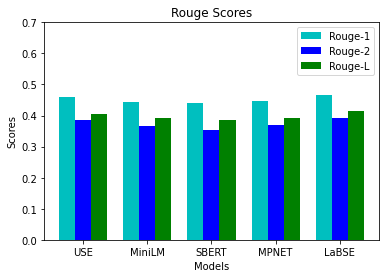

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 5
ind = np.arange(N) 
width = 0.25
model_names = ['USE','MiniLM','SBERT','MPNET','LaBSE']

avals = [0.46078,0.44406,0.44019,0.44809,0.46719]
bar1 = plt.bar(ind, avals, width, color = 'c')

bvals = [0.384493,0.367289, 0.353037, 0.368193, 0.391248]
bar2 = plt.bar(ind+width, bvals, width, color='b')

cvals = [0.406490,0.391956, 0.385843, 0.392966, 0.413039]
bar3 = plt.bar(ind+width*2, cvals, width, color = 'g')


plt.xlabel("Models")
plt.ylabel('Scores')
plt.title("Rouge Scores")

metric = ['Rouge-1', 'Rouge-2', 'Rouge-L']

plt.ylim(0,0.7)

plt.xticks(ind+width,model_names)
plt.legend( (bar1, bar2, bar3), ('Rouge-1', 'Rouge-2', 'Rouge-L'))
plt.show()

In [ ]:
import pandas as pd

a={'Precision' :[0.80801,0.80223,0.74480,0.78595,0.82063],
   'Recall' :[0.46078,0.44406,0.44019,0.44809,0.46719],
   'F1 - Score' :[0.54340,0.53152,0.52176,0.53231,0.55582]}
df = pd.DataFrame(a,index=['USE','MiniLM','SBERT','MPNET','LaBSE'])
df=df.style.set_table_attributes("style='display:inline'").set_caption('Rouge-1 Scores')
df

,Precision,Recall,F1 - Score
USE,0.808010,0.460780,0.543400
MiniLM,0.802230,0.444060,0.531520
SBERT,0.744800,0.440190,0.521760
MPNET,0.785950,0.448090,0.532310
LaBSE,0.820630,0.467190,0.555820


In [ ]:
import pandas as pd

a={'Precision' :[0.717512,0.710975,0.636974, 0.690777,0.735935], 		
   'Recall' :[0.384493,0.367289, 0.353037, 0.368193, 0.391248],
   'F1 - Score' :[0.444098,0.430290,0.408581, 0.428438,0.455330 ]}
df = pd.DataFrame(a,index=['USE','MiniLM','SBERT','MPNET','LaBSE'])
df=df.style.set_table_attributes("style='display:inline'").set_caption('Rouge-2 Scores')
df

,Precision,Recall,F1 - Score
USE,0.717512,0.384493,0.444098
MiniLM,0.710975,0.367289,0.430290
SBERT,0.636974,0.353037,0.408581
MPNET,0.690777,0.368193,0.428438
LaBSE,0.735935,0.391248,0.455330


In [ ]:
import pandas as pd

a={'Precision' :[0.799363,0.792730, 0.731891, 0.775590, 0.812303],
   'Recall' :[0.406490,0.391956, 0.385843, 0.392966, 0.413039],
   'F1 - Score' :[0.537674,0.525156, 0.512734, 0.525185, 0.550080]}
df = pd.DataFrame(a,index=['USE','MiniLM','SBERT','MPNET','LaBSE'])
df=df.style.set_table_attributes("style='display:inline'").set_caption('Rouge-L Scores')
df

,Precision,Recall,F1 - Score
USE,0.799363,0.406490,0.537674
MiniLM,0.792730,0.391956,0.525156
SBERT,0.731891,0.385843,0.512734
MPNET,0.775590,0.392966,0.525185
LaBSE,0.812303,0.413039,0.550080
